## Sarcasm Detection Project for Capstone, ML2



In order to best detect sarcasm across the gamut of human expression (at least in text), I've gone and collected three datasets and sources I find to be decent at being rather notable in terms of sarcasm.

Reddit, Twitter, and Newspaper Headlines.

In terms of accuracy, I belive the Headlines dataset is the least inaccurate in its labeling, as the sarcastic headlines are explicitly from a sarcastic website. I added this to the existing framework for analyzing the reddit dataset, as having concretely aggreable sarcasm might help train the model to be more accurate.

Reddit and Twitter are less clear, though the existence of "/s" as a universal marker for sarcasm on the sites is helpful. I am curious how these affect things.

Goals:

- Create a merged dataset
- Create a deep RNN for NLP
- Train the model on all three different datasets
- Test prediction quality at each step.
- Explore further options.

In [75]:
# pandas to open data files & processing it.
import pandas as pd
# to see all columns
pd.set_option('display.max_columns', None)
# To see whole text
pd.set_option('max_colwidth', None)

# numpy for numeric data processing
import numpy as np

# keras for deep learning model creation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GRU, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, BackupAndRestore, ModelCheckpoint

# to fix random seeds
import random
import tensorflow as tf
import torch
import os

# Regular Expression for text cleaning
import re

# to track the progress - progress bar
from tqdm.notebook import tqdm

Let's open the data files now.

Need to make sure all the Directories are available first, though: 

In [76]:
#import os
if (not os.path.exists("/kaggle")):
    os.mkdir("/kaggle")
if (not os.path.exists("/kaggle/working")):
    os.mkdir("/kaggle/working")
if (not os.path.exists("/kaggle/working/checkpoints")):
    os.mkdir("/kaggle/working/checkpoints")
if (not os.path.exists("/kaggle/working/backup")):
    os.mkdir("/kaggle/working/backup")

In [77]:
working_dir = "/kaggle/working"

In [78]:
twitter_data = pd.read_csv("../input/twitter-sracastic-classification-dataset/Sarcasm.csv", header=0 , usecols= ["tweet", "sarcastic"], dtype={'tweet': "string", 'sarcastic' : "int64"})[["tweet", "sarcastic"]]
print(twitter_data.shape)
twitter_data.head()

(3468, 2)


,tweet,sarcastic
0,The only thing I got from college is a caffeine addiction,1
1,I love it when professors draw a big question mark next to my answer on an exam because I’m always like yeah I don’t either ¯\_(ツ)_/¯,1
2,Remember the hundred emails from companies when Covid started getting real? I’ve gotten three in regards to support for protests. And only @SavageXFenty shared helpful links and actually said black lives matter... we love capitalism 🥰🙌🏼,1
3,Today my pop-pop told me I was not “forced” to go to college 🙃 okay sure sureeee,1
4,"@VolphanCarol @littlewhitty @mysticalmanatee I did too, and I also reported Cancun Cruz not worrying about the heartbeats of his constituents without electricity or heat when he fled to Mexico.",1


In [79]:
twitter_data.dtypes

tweet        string
sarcastic     int64
dtype: object

In [80]:
headline_1_data = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json" , lines = True, dtype= {'headline': str, 'is_sarcastic' : "int64"})[["headline","is_sarcastic"]]
print(headline_1_data.shape)
headline_1_data.head()

(26709, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


In [81]:
headline_1_data.dtypes

headline        object
is_sarcastic     int64
dtype: object

In [82]:
headline_2_data = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json" , lines = True, dtype={'headline': str, 'is_sarcastic' : "int64"}).reset_index()[["headline","is_sarcastic"]]
print(headline_2_data.shape)
headline_2_data.head()

(28619, 2)


,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clock of hair loss,1
1,"dem rep. totally nails why congress is falling short on gender, racial equality",0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting to work,1
4,mother comes pretty close to using word 'streaming' correctly,1


In [83]:
headline_2_data.dtypes

headline        object
is_sarcastic     int64
dtype: object

In [84]:
headline_df = headline_1_data.merge(headline_2_data, how="outer")
headline_df["headline"] = headline_df["headline"].astype("string")
print(headline_df.shape)
headline_df.head()

(29076, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


These first two contain headlines from oline newspapers, but really we only want to know if it's sarcastic and what the words actually are. We want to drop the article_link column. 

In [85]:
headline_df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0
...,...,...
29071,tyson holds contest to let fans submit new ideas for torturing chicken to death,1
29072,increasingly cocky bernie sanders announces he won't take donations over 27 cents,1
29073,cash-strapped zuckerberg forced to sell 11 million facebook users,1
29074,"grocery store bar actually has great little happy hour, reports man with a serious problem",1


In [86]:
# remove empty rows
headline_df.dropna(inplace=True)
headline_df.dtypes

headline        string
is_sarcastic     int64
dtype: object

Great, now we just need to pass it along and process it after we take our much larger sarcasm database from reddit.

The Sarcasm dataset is filled with extraneous data. in order to avoid problems, I will only read the two columns I find necessary (for now):

In [87]:
sarcasm_data = pd.read_csv("../input/sarcasm/train-balanced-sarcasm.csv", header=0 , usecols= ["comment", "label"], dtype={'comment': "string", 'label' : int})[["comment", "label"]]
print(sarcasm_data.shape)
sarcasm_data.tail()


(1010826, 2)


,comment,label
1010821,I'm sure that Iran and N. Korea have the technology to create a pig/bird/human hybrid virus.,1
1010822,"whatever you do, don't vote green!",1
1010823,Perhaps this is an atheist conspiracy to make Christians look bad?,1
1010824,The Slavs got their own country - it is called Kosovo,1
1010825,"values, as in capitalism .. there is good money in imprisoning people ..",1


In [88]:
sarcasm_data.dtypes

comment    string
label       int64
dtype: object

In [89]:
# printing all columns of the dataframe
print(sarcasm_data.columns.tolist())
print(headline_df.columns.tolist())
headline_df.dtypes

['comment', 'label']
['headline', 'is_sarcastic']


headline        string
is_sarcastic     int64
dtype: object

In [90]:
# remove empty rows
sarcasm_data.dropna(inplace=True)
sarcasm_data.tail()

,comment,label
1010821,I'm sure that Iran and N. Korea have the technology to create a pig/bird/human hybrid virus.,1
1010822,"whatever you do, don't vote green!",1
1010823,Perhaps this is an atheist conspiracy to make Christians look bad?,1
1010824,The Slavs got their own country - it is called Kosovo,1
1010825,"values, as in capitalism .. there is good money in imprisoning people ..",1


In [91]:
sarcasm_data

,comment,label
0,NC and NH.,0
1,You do know west teams play against west teams more than east teams right?,0
2,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",0
3,"This meme isn't funny none of the ""new york nigga"" ones are.",0
4,I could use one of those tools.,0
...,...,...
1010821,I'm sure that Iran and N. Korea have the technology to create a pig/bird/human hybrid virus.,1
1010822,"whatever you do, don't vote green!",1
1010823,Perhaps this is an atheist conspiracy to make Christians look bad?,1
1010824,The Slavs got their own country - it is called Kosovo,1


In [92]:
sarcasm_data["comment"].value_counts()

You forgot the                                                                                                        1451
Yes                                                                                                                    470
you forgot the                                                                                                         456
Yes.                                                                                                                   456
Thanks!                                                                                                                396
                                                                                                                      ... 
Upvoted for "retard".                                                                                                    1
Haha, those people were born wrong!                                                                                      1
It just goes to 

So, there are `505368` sentences with sarcastic news headlines !!<br>

Let's do some pre-processing on our text data.<br>
These are the common practices which can improve performance in almost any NLP task.<br><br>

One common thing we can do is to remove `contractions`.<br>
### Like, "ain't" to "is not", "can't" to "can not" etc.

In [93]:
mispell_dict = {"ain't": "is not", "cannot": "can not", "aren't": "are not", "can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "wont": "will not", "won't've": "will not have", "would've": "would have",
                "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
                'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

mispell_dict = {k.lower(): v.lower() for k, v in mispell_dict.items()}

Let's make our preprocessing function.

In [94]:
def preprocessing_text(s):
    # making our string lowercase & removing extra spaces
    s = str(s).lower().strip()
    
    # remove contractions.
    s = " ".join([mispell_dict[word] if word in mispell_dict.keys() else word for word in s.split()])
    
    # removing \n
    s = re.sub('\n', '', s)
    
    # put spaces before & after punctuations to make words seprate. Like "king?" to "king", "?".
    s = re.sub(r"([?!,+=—&%\'\";:¿।।।|\(\){}\[\]//])", r" \1 ", s)
    
    # Remove more than 2 continues spaces with 1 space.
    s = re.sub('[ ]{2,}', ' ', s).strip()
    
    return s

In [95]:
# apply preprocessing_text function, reapply the string typing as well, since that gets lost in this step otherwise.

twitter_data['tweet'] = twitter_data['tweet'].apply(preprocessing_text).astype("string")
headline_df['headline'] = headline_df['headline'].apply(preprocessing_text).astype("string")
sarcasm_data['comment'] = sarcasm_data['comment'].apply(preprocessing_text).astype("string")

In [96]:
sarcasm_data.head()

,comment,label
0,nc and nh.,0
1,you do know west teams play against west teams more than east teams right ?,0
2,"they were underdogs earlier today , but since gronk ' s announcement this afternoon , the vegas line has moved to patriots -1",0
3,"this meme is not funny none of the "" new york nigga "" ones are.",0
4,i could use one of those tools.,0


#  Create Merged Dataset to use in embedding matrix

In [97]:
#rename tweet and label for merging.
twitter_data = twitter_data.rename(columns={'tweet' : 'comment', 'sarcastic' : 'label'})
twitter_data

,comment,label
0,the only thing i got from college is a caffeine addiction,1
1,i love it when professors draw a big question mark next to my answer on an exam because i’m always like yeah i don’t either ¯\_ ( ツ ) _ / ¯,1
2,remember the hundred emails from companies when covid started getting real ? i’ve gotten three in regards to support for protests. and only @savagexfenty shared helpful links and actually said black lives matter... we love capitalism 🥰🙌🏼,1
3,today my pop-pop told me i was not “forced” to go to college 🙃 okay sure sureeee,1
4,"@volphancarol @littlewhitty @mysticalmanatee i did too , and i also reported cancun cruz not worrying about the heartbeats of his constituents without electricity or heat when he fled to mexico.",1
...,...,...
3463,the population spike in chicago in 9 months is about to be ridiculous,0
3464,you would think in the second to last english class of the year my prof would stop calling me sean,0
3465,i’m finally surfacing after a holiday to scotland and a difficult few days with an ill child ( hopefully on the mend now ) . happy september all ! smell the pencil shavings and that new notebook aroma. 1st sept has always seemed a lot more promising than 1st january,0
3466,"could not be prouder today. well done to every student who got their gcses this morning after 18 months that would challenge anyone in history , at any stage in their lives. the teachers did an amazing job. #gcseresults2021 #gcseresults",0


In [98]:
#rename headline and label for merging, as renaming the other database causes a catastrophic spike in memory usage.
print(headline_df.dtypes)
headline_df = headline_df.rename(columns={'headline' : 'comment', 'is_sarcastic' : 'label'})
headline_df.dtypes

headline        string
is_sarcastic     int64
dtype: object


comment    string
label       int64
dtype: object

In [99]:
first_merge = headline_df.merge(twitter_data, how="outer")
first_merge.dtypes

comment    string
label       int64
dtype: object

In [100]:
#Took quite a bit of tries to make sure that it merged a way that didn't nuke all the items.
merged_data = first_merge.merge(sarcasm_data, how="outer")
merged_data["comment"].value_counts()
merged_data.dtypes

comment    string
label       int64
dtype: object

## Create an Embedding Matrix using Merged Database.

In [101]:
# total unique words we are going to use.
TOTAL_WORDS = 60000

# max number of words one sentence can have
MAX_LEN = 50

# width of of 1D embedding vector
EMBEDDING_SIZE = 300

In [102]:
%%time
tokenizer = Tokenizer(num_words=TOTAL_WORDS)
tokenizer.fit_on_texts(list(merged_data['comment']))
train_data = tokenizer.texts_to_sequences(merged_data['comment'])
train_data = pad_sequences(train_data, maxlen = MAX_LEN)
target = merged_data['label']

CPU times: user 36.4 s, sys: 238 ms, total: 36.6 s
Wall time: 36.7 s


In [103]:
def setUpTokenData(dataset, sarcText = "comment", sarcLabel="label"):
    train_data = tokenizer.texts_to_sequences(dataset[sarcText])
    train_data = pad_sequences(train_data, maxlen = MAX_LEN)
    target = dataset[sarcLabel]

    return train_data, target

Let's open embedding file now & store in a matrix.

In [104]:
%%time
# This step takes a whole lot of time, much to my irritation. Try to avoid running this multiple times.
# I've gone and tried to isolate this of from as many re-runnable actions as I could, but it's a beefy one due 2m items. 

EMBEDDING_FILE = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(EMBEDDING_FILE)))

0it [00:00, ?it/s]

CPU times: user 1min 58s, sys: 6.75 s, total: 2min 5s
Wall time: 2min 11s


In [105]:
#_, _, sarcasm_tokenizer = setUpTokenData(sarcasm_data, "comment", "label")
word_index = tokenizer.word_index
nb_words = min(TOTAL_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_SIZE))

In [106]:
for word, i in tqdm(word_index.items()):
    if i >= TOTAL_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

  0%|          | 0/171936 [00:00<?, ?it/s]

## Let's build our NLP deep learning model now..

In [107]:
embedding_matrix.shape

(60000, 300)

In [108]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    tf.random.set_seed(seed)

# We fix all the random seed so that, we can reproduce the results.
seed_everything(42)

In [109]:
#It's less effort to just create a simple Leaky Relu function than to implement it otherwise.
def myLeakyRelu(z):
    return tf.maximum(z, tf.multiply(z,0.01))

In [110]:
from keras.layers import GRU
def createModel(learning_rate = 0.0001):

    input_layer = Input(shape=(MAX_LEN,))

    embedding_layer = Embedding(TOTAL_WORDS, EMBEDDING_SIZE, weights = [embedding_matrix])(input_layer)

    GRU_layer = Bidirectional(GRU(128, return_sequences = True))(embedding_layer)
    
    LSTM_layer = Bidirectional(LSTM(128, return_sequences = True))(GRU_layer)
    l_maxpool_layer = GlobalMaxPool1D()(LSTM_layer)

    dense_layer_0 = Dense(128, activation=myLeakyRelu)(l_maxpool_layer)
    dropout_0 = Dropout(0.4)(dense_layer_0)
    
    dense_layer_1 = Dense(64, activation=myLeakyRelu)(dropout_0)
    dropout_1 = Dropout(0.5)(dense_layer_1)

    dense_layer_2 = Dense(32, activation="selu")(dropout_1)
    dropout_2 = Dropout(0.5)(dense_layer_2)
    
    dense_layer_3 = Dense(16, activation="selu")(dropout_2)
    dropout_3 = Dropout(0.5)(dense_layer_3)
    
    dense_layer_4 = Dense(8, activation="selu")(dropout_3)
    dropout_4 = Dropout(0.2)(dense_layer_4)
    
    dense_layer_5 = Dense(4, activation="relu")(dropout_4)
    dropout_5 = Dropout(0.2)(dense_layer_5)

    output_layer = Dense(1, activation="sigmoid")(dropout_5)

    default_model = Model(inputs=input_layer, outputs=output_layer)

    default_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    default_model.summary()
    return default_model


default_model = createModel()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 50, 300)           18000000  
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 50, 256)           330240    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 50, 256)           394240    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 256)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_60 (Dropout)         (None, 128)               0  

## Before training the model first, let's understand our model first.

`input_layer` : Input layer with which we will get text sentence.<br><br>
`embedding_layer` : Embedding layer with which we will map each word with it's corresponding embedding vector.<br><br>
`GRU_layer` : GRU layer with 128 GRU cells.
* We are using Bidirectional to run GRU from both side of the text sentence.
    1. Left to Right
    2. Right to Left
* Purpose of this is to give our model both side context.
* It's also possible to not use this. But using this have provided good results.
<br><br>
`maxpool_layer` : Max pool layer is used to minimize the image size by pooling maximum number out of 2x2 grid.
<br><br>

`LSTM_layer` : LSTM layer with 128 GRU cells. Otherwise same as above.
<br><br>
`maxpool_layer` : Same as above.
<br><br>
`dense_layer_0` : Feed-forward dense layer to classify the features captured by LSTM layer.
<br><br>
`dropout_0` : Dropout is interesting trick. In Dropout, we randomly turn off some percentage of our neurons so that their's output can't go to next layer. Here we are turning off 20% of our total neurons.
* Purpose of doing this is again to make our training robust.
* Network should not depend some specific neurons to make predictions. And random turn will allow us to do that.
<br><br>
The subsequent dense and dropout layers are the same as above.
<br><br>
`output_layer` : To get the output prediction from the neural network.


### Side note: I cannot for the life of me figure out how to format these blocks. It's just not happening.

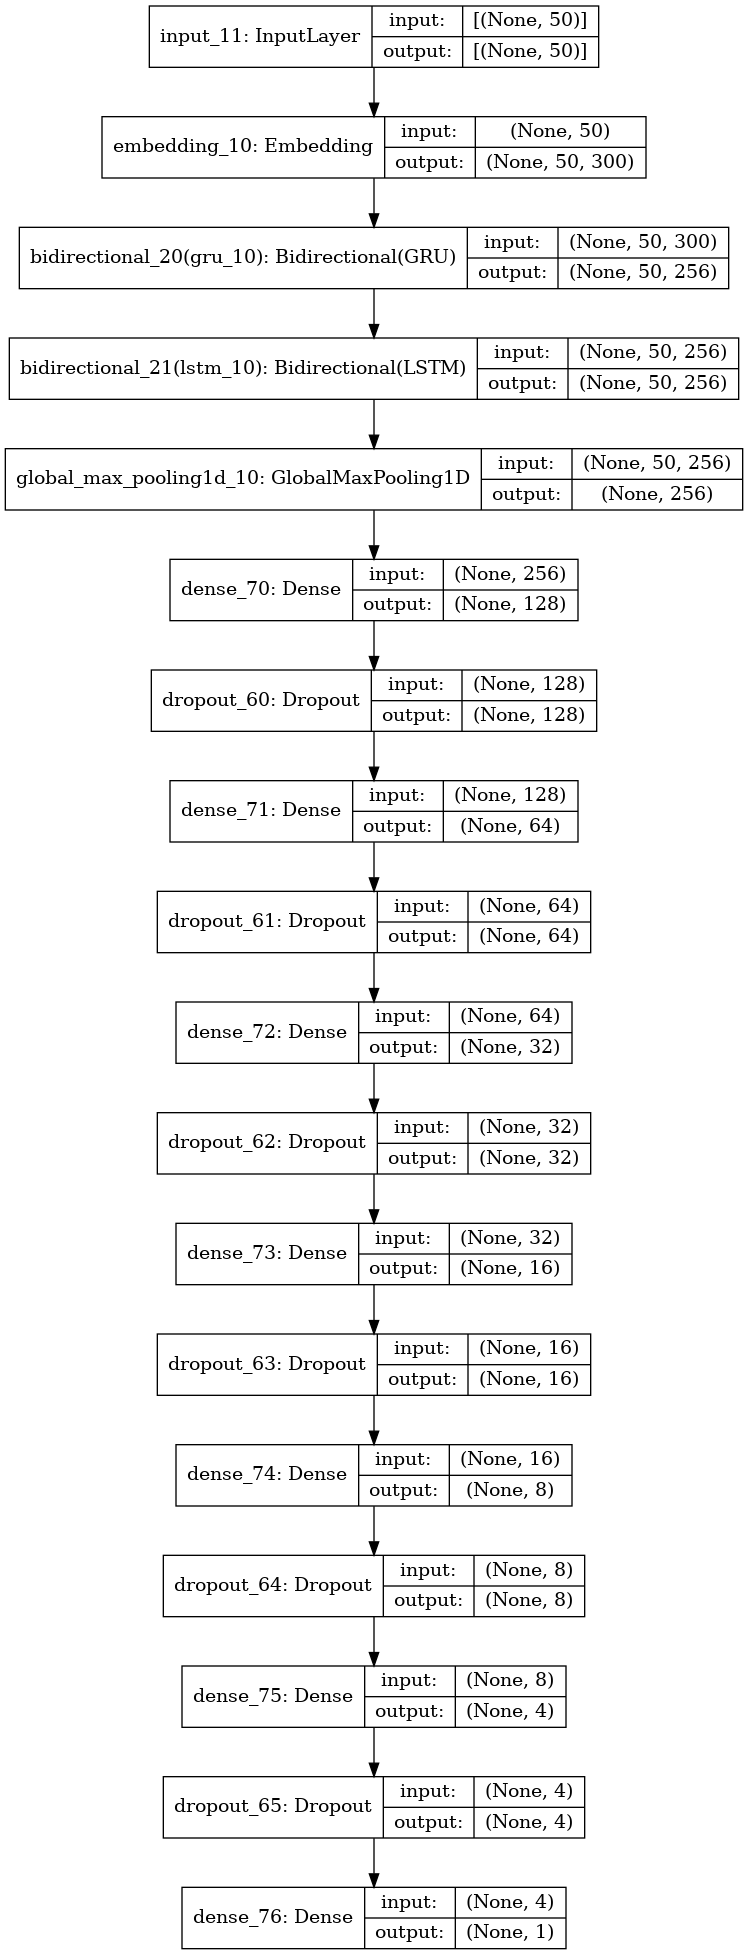

In [111]:
plot_model(default_model, show_shapes=True)

## Let's start the training of our model

In [112]:
#Callbacks because of course we will.
checkpoint_path = '/kaggle/working/checkpoints/checkpoint'
backup_path = '/kaggle/working/backup/backup'


es = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience = 6, verbose = 1)
ac_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = 1)
loss_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)

callbacks = [es, ac_ckpt]
l_callbacks = [es, loss_ckpt]

In [113]:
%%time
BATCH_SIZE = 512
EPOCHS = 2

def trainModelOnDataset(dataset,
                        sarcText = "text",
                        sarcLabel = "label",
                        BATCH_SIZE = 512,
                        EPOCHS = 2,
                        model= default_model,
                        learning_rate=0.001, callbacks = callbacks):
    
    training_data, target_labels = setUpTokenData(dataset, sarcText, sarcLabel)

    history = model.fit(
        training_data, target_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
        # We are using randomly selected 20% sentences as validation data.
        validation_split=0.2,
        callbacks = callbacks
    )

CPU times: user 0 ns, sys: 627 µs, total: 627 µs
Wall time: 637 µs


### Smallest Twitter Dataset Training.

In [114]:
%%time
#Let's first try to train on the smaller dataset for speed.
#With such a smaller dataset, we can run for many epochs but we don't want to overfit, so our learning rate is really small.
slowest_model = createModel(learning_rate = 0.00001)
modelHistory = trainModelOnDataset(twitter_data, "comment", EPOCHS = 100, model=slowest_model, callbacks = l_callbacks)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 50, 300)           18000000  
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 50, 256)           330240    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 50, 256)           394240    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 256)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_66 (Dropout)         (None, 128)               0  

### Create Sentence Processing/Prediction functions.

In [115]:
def processed_Sentence(sentence):
    
    sentence = preprocessing_text(sentence)
    print("\"%s\""%sentence)

    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen = MAX_LEN)
    return sentence

In [116]:
def predict_text(sentence, model = default_model):
    # Make the prediction.
    prediction = model.predict(processed_Sentence(sentence))
    #print(prediction[0][0])
    print("Sarcasm Probability of %.3f percent \n"%(prediction[0][0]*100))

In [117]:
predict_text("sun rises in the east")
predict_text("Biden sucks brains from monkeys.")
predict_text("Trump sucks brains from monkeys.")
predict_text("Oh, you're really killing it, huh?")

"sun rises in the east"
Sarcasm Probability of 50.605 percent 

"biden sucks brains from monkeys."
Sarcasm Probability of 51.515 percent 

"trump sucks brains from monkeys."
Sarcasm Probability of 51.404 percent 

"oh , you are really killing it , huh ?"
Sarcasm Probability of 52.713 percent 



### Middling ain't bad. Still, it's really not seeing sarcasm here. 
t can't really detect sarcasm, though at least it defers to not being sarcastic by default. That's at least a mixed blessing there.

### Next, let's use database samples with explicit labels, to test the accuracy of this rather overfit model.

In [118]:
sarcComList = list(sarcasm_data[sarcasm_data['label']==1].sample(20)["comment"])
plainComList = list(sarcasm_data[sarcasm_data['label']==0].sample(20)["comment"])
print(sarcComList)
print()
print(plainComList)

['rules state no oc characters except for sage , crow bartender , and ndgo !', 'but i thought his super duper analytical mind was impervious to any home team fan tendencies.', 'yeah , everyone who plays ironman just for fun is playing it wrong', 'no , they do not want to admit that the soviets did but have a sizable or powerful navy during the second world war.', 'alright peyton , time to come back from this deficit and pump up your team like you have done all season long', 'someone get this man some cobalt loopers asap', 'a pro is using it , everything a pro uses will grant you global within a week of use', 'i do not know...cow farts are pretty great', 'when you are really serious , end it with a serious tag , like this :', 'it does not matter man the dlc just came out !', 'typical christian who does not like minorities', 'take that plasti-dip off that car now.', 'how about " slim reaper " ?', 'successful parenting is brainwashing your child to only enjoy your interests rather than al

Let's see how well it does with a sample of comments that are actually sarcastic, pulled from the reddit sarcasm database. There is 0 intersection between the training dataset and this, so I'm curious what the results might be.

In [119]:
for comment in tqdm(sarcComList):
    predict_text(comment, slowest_model)

  0%|          | 0/20 [00:00<?, ?it/s]

"rules state no oc characters except for sage , crow bartender , and ndgo !"
Sarcasm Probability of 46.955 percent 

"but i thought his super duper analytical mind was impervious to any home team fan tendencies."
Sarcasm Probability of 47.281 percent 

"yeah , everyone who plays ironman just for fun is playing it wrong"
Sarcasm Probability of 47.393 percent 

"no , they do not want to admit that the soviets did but have a sizable or powerful navy during the second world war."
Sarcasm Probability of 45.935 percent 

"alright peyton , time to come back from this deficit and pump up your team like you have done all season long"
Sarcasm Probability of 46.456 percent 

"someone get this man some cobalt loopers asap"
Sarcasm Probability of 47.098 percent 

"a pro is using it , everything a pro uses will grant you global within a week of use"
Sarcasm Probability of 48.152 percent 

"i do not know...cow farts are pretty great"
Sarcasm Probability of 47.014 percent 

"when you are really seriou

Now this is a pretty interesting situation. Some of these are seen as incredibly likely options for sarcasm, and some of them are really not. The model is very unsure on many of these selections, but I'm actually really excited by these results, regardless. In most of the cases, dataset-labeled sarcastic comments got a 50%+ confidence in being sarcastic. That's.... better than a coin flip, at least.

In [120]:
for comment in tqdm(plainComList):
    predict_text(comment, slowest_model)

  0%|          | 0/20 [00:00<?, ?it/s]

"her face reminds me of sylvester stallone"
Sarcasm Probability of 46.817 percent 

"i hate live action , this trailer never got me"
Sarcasm Probability of 46.858 percent 

"with lowry defending him !"
Sarcasm Probability of 48.266 percent 

"have you heard the word of 3.5gb ?"
Sarcasm Probability of 44.737 percent 

"so *that ' s* how they are still in business."
Sarcasm Probability of 47.025 percent 

"my lumia 928 ( released may 2013 ) is running windows 10 tech preview."
Sarcasm Probability of 46.438 percent 

"i can not tell if you are being sarcastic or serious..."
Sarcasm Probability of 47.097 percent 

"am american and consider myself fairly knowledgeable about politics...still do not understand."
Sarcasm Probability of 47.900 percent 

"i am ready to go down this rabbit hole."
Sarcasm Probability of 46.496 percent 

"was a decent movie"
Sarcasm Probability of 47.427 percent 

"same with counterfeit."
Sarcasm Probability of 46.291 percent 

"you are aware jfk died before we wen

Alright, well, I had hoped for a fairly capable model based on the data I'd prepared, but this is actually quite surprising, overall. 

### Swift but effective.

Issues I see pretty clearly though: Incredibly high Val Loss. In fact it's just gowing despite the increased accuracy.<br>
We can see validation accuracy above, which is good, but can be better. 

My initial intentions were to use a smaller, more explicitly defined dataset like the headlines dataset in order to set the path for sarcasm detection pretty quickly. I have since learned that the use of this first dataset causes significant overfitting, very aggressive. It is surprisingly accurate, regardless, however.

Feel free to test out a sarcastic phrase by using the simple "predict_text()" function if you're curious about a specific one.

In [121]:
predict_text("placeholder")

"placeholder"
Sarcasm Probability of 50.675 percent 



### Slightly Smaller Headline Dataset Training.

In [122]:
%%time
#Let's first try to train on the smaller dataset for speed.
#With such a smaller dataset, we can run for many epochs but we don't want to overfit, so our learning rate is really small.
slow_model = createModel(learning_rate = 0.0001)
slow_model.load_weights(checkpoint_path)
modelHistory = trainModelOnDataset(headline_df, "comment", EPOCHS = 100, model=slow_model)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 50, 300)           18000000  
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 50, 256)           330240    
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 50, 256)           394240    
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 256)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_72 (Dropout)         (None, 128)               0  

In [123]:
print("The sarcastic list:\n\n")
for comment in tqdm(sarcComList):
    predict_text(comment, slow_model)
    

print("\n\nThe plain list:\n\n")
for comment in tqdm(plainComList):
    predict_text(comment, slow_model)

The sarcastic list:




  0%|          | 0/20 [00:00<?, ?it/s]

"rules state no oc characters except for sage , crow bartender , and ndgo !"
Sarcasm Probability of 50.536 percent 

"but i thought his super duper analytical mind was impervious to any home team fan tendencies."
Sarcasm Probability of 40.105 percent 

"yeah , everyone who plays ironman just for fun is playing it wrong"
Sarcasm Probability of 50.536 percent 

"no , they do not want to admit that the soviets did but have a sizable or powerful navy during the second world war."
Sarcasm Probability of 4.357 percent 

"alright peyton , time to come back from this deficit and pump up your team like you have done all season long"
Sarcasm Probability of 18.120 percent 

"someone get this man some cobalt loopers asap"
Sarcasm Probability of 50.094 percent 

"a pro is using it , everything a pro uses will grant you global within a week of use"
Sarcasm Probability of 1.961 percent 

"i do not know...cow farts are pretty great"
Sarcasm Probability of 44.329 percent 

"when you are really serious 

  0%|          | 0/20 [00:00<?, ?it/s]

"her face reminds me of sylvester stallone"
Sarcasm Probability of 27.196 percent 

"i hate live action , this trailer never got me"
Sarcasm Probability of 28.026 percent 

"with lowry defending him !"
Sarcasm Probability of 36.772 percent 

"have you heard the word of 3.5gb ?"
Sarcasm Probability of 16.002 percent 

"so *that ' s* how they are still in business."
Sarcasm Probability of 7.065 percent 

"my lumia 928 ( released may 2013 ) is running windows 10 tech preview."
Sarcasm Probability of 2.522 percent 

"i can not tell if you are being sarcastic or serious..."
Sarcasm Probability of 9.392 percent 

"am american and consider myself fairly knowledgeable about politics...still do not understand."
Sarcasm Probability of 13.711 percent 

"i am ready to go down this rabbit hole."
Sarcasm Probability of 50.536 percent 

"was a decent movie"
Sarcasm Probability of 43.682 percent 

"same with counterfeit."
Sarcasm Probability of 49.347 percent 

"you are aware jfk died before we went t

### Larger Reddit Sarcasm Dataset Training.

In [124]:
%%time
#Let's try to train on the unmerged sarcasm dataset for accuracy. With such a large dataset, we can get a hefty change in effects, with a higher learning rate to compensate.
default_model = createModel(learning_rate = 0.005)
default_model.load_weights(checkpoint_path)
modelHistory = trainModelOnDataset(sarcasm_data, "comment", EPOCHS = 20, model = default_model)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 50, 300)           18000000  
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 50, 256)           330240    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 50, 256)           394240    
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 256)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_78 (Dropout)         (None, 128)               0  

In [125]:
print("The sarcastic list:\n\n")
for comment in tqdm(sarcComList):
    predict_text(comment)
    

print("\n\nThe plain list:\n\n")
for comment in tqdm(plainComList):
    predict_text(comment)

The sarcastic list:




  0%|          | 0/20 [00:00<?, ?it/s]

"rules state no oc characters except for sage , crow bartender , and ndgo !"
Sarcasm Probability of 51.978 percent 

"but i thought his super duper analytical mind was impervious to any home team fan tendencies."
Sarcasm Probability of 55.614 percent 

"yeah , everyone who plays ironman just for fun is playing it wrong"
Sarcasm Probability of 50.055 percent 

"no , they do not want to admit that the soviets did but have a sizable or powerful navy during the second world war."
Sarcasm Probability of 51.013 percent 

"alright peyton , time to come back from this deficit and pump up your team like you have done all season long"
Sarcasm Probability of 50.000 percent 

"someone get this man some cobalt loopers asap"
Sarcasm Probability of 51.781 percent 

"a pro is using it , everything a pro uses will grant you global within a week of use"
Sarcasm Probability of 52.390 percent 

"i do not know...cow farts are pretty great"
Sarcasm Probability of 54.109 percent 

"when you are really seriou

  0%|          | 0/20 [00:00<?, ?it/s]

"her face reminds me of sylvester stallone"
Sarcasm Probability of 52.905 percent 

"i hate live action , this trailer never got me"
Sarcasm Probability of 51.151 percent 

"with lowry defending him !"
Sarcasm Probability of 50.747 percent 

"have you heard the word of 3.5gb ?"
Sarcasm Probability of 52.226 percent 

"so *that ' s* how they are still in business."
Sarcasm Probability of 50.233 percent 

"my lumia 928 ( released may 2013 ) is running windows 10 tech preview."
Sarcasm Probability of 52.513 percent 

"i can not tell if you are being sarcastic or serious..."
Sarcasm Probability of 51.891 percent 

"am american and consider myself fairly knowledgeable about politics...still do not understand."
Sarcasm Probability of 51.139 percent 

"i am ready to go down this rabbit hole."
Sarcasm Probability of 50.203 percent 

"was a decent movie"
Sarcasm Probability of 52.047 percent 

"same with counterfeit."
Sarcasm Probability of 51.329 percent 

"you are aware jfk died before we wen

### Let's try to run training on the total dataset now. No learning rate changes<br>

### Largest Merged Dataset Training.

In [126]:
%%time
#Let's try to train on the massive dataset for accuracy. With only 5 epochs we need a fast enough learning rate to compensate
fast_model = createModel(learning_rate = 0.01)
fast_model.load_weights(checkpoint_path)
modelHistory = trainModelOnDataset(merged_data, "comment", EPOCHS = 20, model = fast_model)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 50, 300)           18000000  
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 50, 256)           330240    
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 50, 256)           394240    
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 256)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_84 (Dropout)         (None, 128)               0  

Alright, so that's a far more robust training, if I do say so myself. After all that, I'm certain there's got to be changes. Let's run the predictions on the same list of comments from before, to see what's up.

In [127]:
print("The sarcastic list:\n\n")
for comment in tqdm(sarcComList):
    predict_text(comment, fast_model)
    

print("\n\nThe plain list:\n\n")
for comment in tqdm(plainComList):
    predict_text(comment, fast_model)

The sarcastic list:




  0%|          | 0/20 [00:00<?, ?it/s]

"rules state no oc characters except for sage , crow bartender , and ndgo !"
Sarcasm Probability of 51.664 percent 

"but i thought his super duper analytical mind was impervious to any home team fan tendencies."
Sarcasm Probability of 57.358 percent 

"yeah , everyone who plays ironman just for fun is playing it wrong"
Sarcasm Probability of 57.358 percent 

"no , they do not want to admit that the soviets did but have a sizable or powerful navy during the second world war."
Sarcasm Probability of 23.733 percent 

"alright peyton , time to come back from this deficit and pump up your team like you have done all season long"
Sarcasm Probability of 54.719 percent 

"someone get this man some cobalt loopers asap"
Sarcasm Probability of 41.146 percent 

"a pro is using it , everything a pro uses will grant you global within a week of use"
Sarcasm Probability of 46.467 percent 

"i do not know...cow farts are pretty great"
Sarcasm Probability of 33.580 percent 

"when you are really seriou

  0%|          | 0/20 [00:00<?, ?it/s]

"her face reminds me of sylvester stallone"
Sarcasm Probability of 10.462 percent 

"i hate live action , this trailer never got me"
Sarcasm Probability of 44.946 percent 

"with lowry defending him !"
Sarcasm Probability of 57.358 percent 

"have you heard the word of 3.5gb ?"
Sarcasm Probability of 57.358 percent 

"so *that ' s* how they are still in business."
Sarcasm Probability of 56.730 percent 

"my lumia 928 ( released may 2013 ) is running windows 10 tech preview."
Sarcasm Probability of 34.043 percent 

"i can not tell if you are being sarcastic or serious..."
Sarcasm Probability of 56.514 percent 

"am american and consider myself fairly knowledgeable about politics...still do not understand."
Sarcasm Probability of 18.627 percent 

"i am ready to go down this rabbit hole."
Sarcasm Probability of 10.323 percent 

"was a decent movie"
Sarcasm Probability of 33.103 percent 

"same with counterfeit."
Sarcasm Probability of 41.738 percent 

"you are aware jfk died before we wen

In [128]:
predict_text("sun rises in the east", fast_model)
predict_text("Biden sucks brains from monkeys.", fast_model)
predict_text("Trump sucks brains from monkeys.", fast_model)
predict_text("Oh, you're really killing it, huh?", fast_model)
predict_text("I'm genuinely happy for you.", fast_model)

"sun rises in the east"
Sarcasm Probability of 37.525 percent 

"biden sucks brains from monkeys."
Sarcasm Probability of 56.543 percent 

"trump sucks brains from monkeys."
Sarcasm Probability of 49.948 percent 

"oh , you are really killing it , huh ?"
Sarcasm Probability of 57.358 percent 

"i am genuinely happy for you."
Sarcasm Probability of 16.733 percent 



Well.... that's disappointing. We've clearly missed the mark. Perhaps we've aggressively underfit at this point? It's accurately showing the more sarcastic statements as sarcastic,but by an incredibly small percentage. Odd.

Wacky Results, for sure. It seems as though we have an extremely hesitant categorization, regardless of the source. That's rather unfortunate. 

As a final, simple thought: I severely screwed the pooch somewhere when I added all these smaller datasets to my results, for sure. If I did it over again and had time, I might just focus on the main dataset. I had plans for the smaller datasets to help ease the process, by accelerating the general learning curve, but clearly I was wrong. 

Oh well.

In [129]:
%%time
#As a final attempt, an unaltered model will be run off the merged dataset 
#without any of the prior weights, just to test our hypothesis.
#A slightly faster than default learning rate has been chosen to see what changes that has.
last_model = createModel(learning_rate = 0.005)
modelHistory = trainModelOnDataset(merged_data, "comment", EPOCHS = 20, model = last_model)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 50, 300)           18000000  
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 50, 256)           330240    
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 50, 256)           394240    
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 256)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_90 (Dropout)         (None, 128)               0  

In [130]:
predict_text("Isn't it great that, your girlfriend dumped you?", last_model)

"is not it great that , your girlfriend dumped you ?"
Sarcasm Probability of 75.448 percent 



In [131]:
print("The sarcastic list:\n\n")
for comment in tqdm(sarcComList):
    predict_text(comment, last_model)
    

print("\n\nThe plain list:\n\n")
for comment in tqdm(plainComList):
    predict_text(comment, last_model)

The sarcastic list:




  0%|          | 0/20 [00:00<?, ?it/s]

"rules state no oc characters except for sage , crow bartender , and ndgo !"
Sarcasm Probability of 59.735 percent 

"but i thought his super duper analytical mind was impervious to any home team fan tendencies."
Sarcasm Probability of 77.004 percent 

"yeah , everyone who plays ironman just for fun is playing it wrong"
Sarcasm Probability of 77.004 percent 

"no , they do not want to admit that the soviets did but have a sizable or powerful navy during the second world war."
Sarcasm Probability of 20.790 percent 

"alright peyton , time to come back from this deficit and pump up your team like you have done all season long"
Sarcasm Probability of 39.173 percent 

"someone get this man some cobalt loopers asap"
Sarcasm Probability of 47.316 percent 

"a pro is using it , everything a pro uses will grant you global within a week of use"
Sarcasm Probability of 23.154 percent 

"i do not know...cow farts are pretty great"
Sarcasm Probability of 43.503 percent 

"when you are really seriou

  0%|          | 0/20 [00:00<?, ?it/s]

"her face reminds me of sylvester stallone"
Sarcasm Probability of 4.163 percent 

"i hate live action , this trailer never got me"
Sarcasm Probability of 47.172 percent 

"with lowry defending him !"
Sarcasm Probability of 34.078 percent 

"have you heard the word of 3.5gb ?"
Sarcasm Probability of 77.004 percent 

"so *that ' s* how they are still in business."
Sarcasm Probability of 39.672 percent 

"my lumia 928 ( released may 2013 ) is running windows 10 tech preview."
Sarcasm Probability of 21.977 percent 

"i can not tell if you are being sarcastic or serious..."
Sarcasm Probability of 52.166 percent 

"am american and consider myself fairly knowledgeable about politics...still do not understand."
Sarcasm Probability of 12.713 percent 

"i am ready to go down this rabbit hole."
Sarcasm Probability of 13.458 percent 

"was a decent movie"
Sarcasm Probability of 19.558 percent 

"same with counterfeit."
Sarcasm Probability of 36.989 percent 

"you are aware jfk died before we went

Well. At least it tried.

Initial Sources 

"Twitter sracastic dataset for sarcasm detection"
https://www.kaggle.com/datasets/farhanch67/twitter-sracastic-classification-dataset

"Are you being sarcastic" notebook/lesson by PRASHANT KIKANI
https://www.kaggle.com/code/prashantkikani/are-you-being-sarcastic-sarcasm-detection-nlp

News Headlines Dataset for Sarcasm Detection
https://rishabhmisra.github.io/publications/
1. Misra, Rishabh and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).
2. Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).


Notable changes include

- Conversion to a more function-centric process, allowing for more flexibility if needed.
- Updates to code to follow more recent convention (as of Dec-7-22)
- Expanded tests of prediction, for a more thorough examination.
- Additional dataset used to compare thoroughness of training.
- Various personal changes to add nuance and explore the interactions of the various datasets.


The below text is an easter egg for use elsewhere.... shhhh

In [134]:
#Presentation Quotes:
predict_text("You really think I’m being Sarcastic?", last_model)
predict_text("Cause I’m not", last_model)
predict_text("You must be confused", last_model)
predict_text("I Never use sarcasm, in fact", last_model)
predict_text("I don’t even know what Sarcasm Is", last_model)
predict_text("I had no idea what I was doing", last_model)
predict_text("I don’t even know what I’m doing now", last_model)
predict_text("Why Bother Saying anything", last_model)
predict_text("I Wonder if Zoolander knew sarcasm", last_model)
predict_text("What now?", last_model)
predict_text("How's this supposed to end?", last_model)

"you really think i’m being sarcastic ?"
Sarcasm Probability of 48.788 percent 

"cause i’m not"
Sarcasm Probability of 55.632 percent 

"you must be confused"
Sarcasm Probability of 61.944 percent 

"i never use sarcasm , in fact"
Sarcasm Probability of 65.356 percent 

"i don’t even know what sarcasm is"
Sarcasm Probability of 59.291 percent 

"i had no idea what i was doing"
Sarcasm Probability of 19.941 percent 

"i don’t even know what i’m doing now"
Sarcasm Probability of 6.231 percent 

"why bother saying anything"
Sarcasm Probability of 59.743 percent 

"i wonder if zoolander knew sarcasm"
Sarcasm Probability of 77.004 percent 

"what now ?"
Sarcasm Probability of 17.887 percent 

"how is this supposed to end ?"
Sarcasm Probability of 50.576 percent 

